In [4]:
from pathlib import Path
import glob
from collections import Counter

BASE = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW  = BASE / "data" / "raw_images"

EXTS = ("*.jpg","*.jpeg","*.png","*.bmp")  # lowercase only; Windows will match both cases

def list_images(folder):
    files = []
    for e in EXTS:
        files += glob.glob(str(folder / e))
    # dedup in case the OS/patterns still overlap
    files = list(dict.fromkeys(files))
    return files

tot = 0
per_class, per_ext = {}, {}
for cls in map(str, range(10)):
    files = list_images(RAW/cls)
    per_class[cls] = len(files)
    per_ext[cls] = dict(Counter([Path(f).suffix.lower() for f in files]))
    tot += len(files)

print("Total images:", tot)
print("Per-class counts:", per_class)
print("Per-class extension breakdown:", per_ext)



Total images: 2062
Per-class counts: {'0': 205, '1': 206, '2': 206, '3': 206, '4': 207, '5': 207, '6': 207, '7': 206, '8': 208, '9': 204}
Per-class extension breakdown: {'0': {'.jpg': 205}, '1': {'.jpg': 206}, '2': {'.jpg': 206}, '3': {'.jpg': 206}, '4': {'.jpg': 207}, '5': {'.jpg': 207}, '6': {'.jpg': 207}, '7': {'.jpg': 206}, '8': {'.jpg': 208}, '9': {'.jpg': 204}}


In [5]:
from pathlib import Path
import os, shutil, glob, cv2, numpy as np
from tqdm import tqdm
import mediapipe as mp
from sklearn.model_selection import train_test_split
from lxml import etree

BASE = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW  = BASE / "data" / "raw_images"     # your 0..9 folders
WS   = BASE / "Tensorflow" / "workspace"
IMGS = WS / "images"                    # outputs here
ANN  = WS / "annotations"

SPLIT_TEST = 0.20
CLEAN_RUN = True

for p in [IMGS/"train", IMGS/"test", ANN]:
    p.mkdir(parents=True, exist_ok=True)

if CLEAN_RUN:  # wipe previous duplicates
    for sub in ["train","test"]:
        for f in (IMGS/sub).glob("*"):
            f.unlink()

EXTS = ("*.jpg","*.jpeg","*.png","*.bmp")  # lowercase only

def list_images(folder):
    files = []
    for e in EXTS:
        files += glob.glob(str(folder / e))
    return list(dict.fromkeys(files))  # dedup

# collect
pairs = []
for cls in map(str, range(10)):
    for f in list_images(RAW/cls):
        pairs.append((Path(f), int(cls)))
print(f"Found {len(pairs)} images across 10 classes (deduped).")
assert pairs

# mediapipe detector
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def lm_to_bbox(lms):
    xs = [lm.x for lm in lms]; ys = [lm.y for lm in lms]
    x1, x2 = max(0.0, min(xs)), min(1.0, max(xs))
    y1, y2 = max(0.0, min(ys)), min(1.0, max(ys))
    mx = 0.05*(x2-x1+1e-6); my = 0.05*(y2-y1+1e-6)
    return max(0.0,x1-mx), max(0.0,y1-my), min(1.0,x2+mx), min(1.0,y2+my)

from lxml import etree
def write_voc_xml(dst_img, w, h, xyxy, cls_name):
    x1,y1,x2,y2 = xyxy
    ann = etree.Element("annotation")
    etree.SubElement(ann, "filename").text = dst_img.name
    size = etree.SubElement(ann, "size")
    etree.SubElement(size, "width").text  = str(w)
    etree.SubElement(size, "height").text = str(h)
    etree.SubElement(size, "depth").text  = "3"
    obj = etree.SubElement(ann, "object")
    etree.SubElement(obj, "name").text = str(cls_name)
    bb = etree.SubElement(obj, "bndbox")
    etree.SubElement(bb, "xmin").text = str(int(max(1, x1)))
    etree.SubElement(bb, "ymin").text = str(int(max(1, y1)))
    etree.SubElement(bb, "xmax").text = str(int(min(w, x2)))
    etree.SubElement(bb, "ymax").text = str(int(min(h, y2)))
    return etree.tostring(ann, pretty_print=True)

# split and write
idx = np.arange(len(pairs))
y_cls = np.array([c for _, c in pairs])
tr_idx, te_idx = train_test_split(idx, test_size=SPLIT_TEST, stratify=y_cls, random_state=42)

def process(indices, split):
    miss = 0
    for i in tqdm(indices, desc=split):
        src, cls = pairs[i]
        img = cv2.imread(str(src)); 
        if img is None: 
            print("Unreadable:", src); 
            continue
        h, w = img.shape[:2]
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = mp_hands.process(rgb)

        if res.multi_hand_landmarks:
            x1n,y1n,x2n,y2n = lm_to_bbox(res.multi_hand_landmarks[0].landmark)
        else:
            miss += 1
            x1n,y1n,x2n,y2n = 0.0,0.0,1.0,1.0

        xyxy = (x1n*w, y1n*h, x2n*w, y2n*h)
        stem = f"{cls}_{src.stem}_{i:06d}"
        dst_img = IMGS/split/f"{stem}{src.suffix.lower()}"
        dst_xml = IMGS/split/f"{stem}.xml"

        shutil.copy(str(src), str(dst_img))
        xml = write_voc_xml(dst_img, w, h, xyxy, cls)
        with open(dst_xml, "wb") as f: f.write(xml)
    print(f"[{split}] fallbacks (no hand found): {miss}")

process(tr_idx, "train")
process(te_idx, "test")

# label map (IDs 1..10)
label_map = "\n".join([f"item {{\n  name: \"{i}\"\n  id: {i+1}\n}}\n" for i in range(10)])
(ANN/"label_map.pbtxt").write_text(label_map)
print("DONE. Check:", IMGS)


Found 2062 images across 10 classes (deduped).


train:   0%|                                                                                  | 0/1649 [00:00<?, ?it/s]C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
train: 100%|███████████████████████████████████████████████████████████████████████| 1649/1649 [04:03<00:00,  6.79it/s]


[train] fallbacks (no hand found): 276


test: 100%|██████████████████████████████████████████████████████████████████████████| 413/413 [01:07<00:00,  6.11it/s]

[test] fallbacks (no hand found): 69
DONE. Check: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\Tensorflow\workspace\images


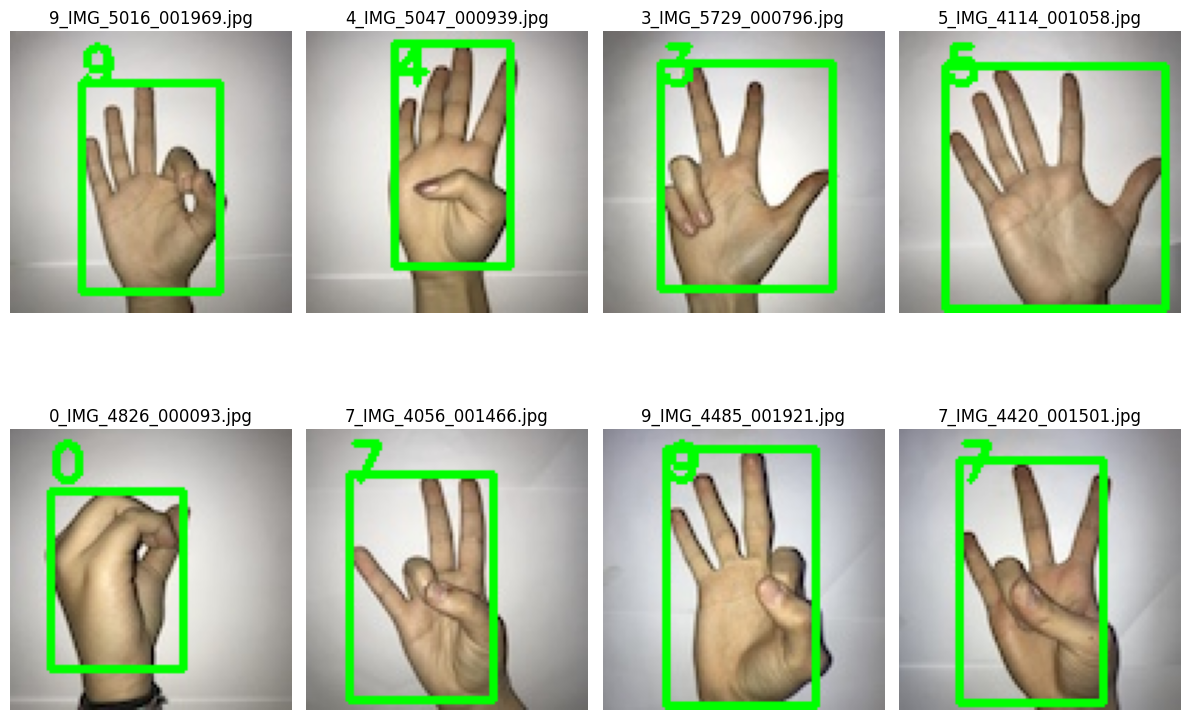

In [6]:
from pathlib import Path
import random, cv2, xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

IMGS_TRAIN = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\Tensorflow\workspace\images\train")

xmls = list(IMGS_TRAIN.glob("*.xml"))
samples = random.sample(xmls, min(8, len(xmls)))

plt.figure(figsize=(12,9))
for i, xp in enumerate(samples):
    root = ET.parse(xp).getroot()
    fn = root.find('filename').text
    img = cv2.imread(str(IMGS_TRAIN / fn))

    for obj in root.findall('object'):
        name = obj.find('name').text
        b = obj.find('bndbox')
        x1,y1,x2,y2 = [int(b.find(t).text) for t in ('xmin','ymin','xmax','ymax')]
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, name, (x1, max(18,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    plt.subplot(2,4,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(fn); plt.axis('off')
plt.tight_layout(); plt.show()


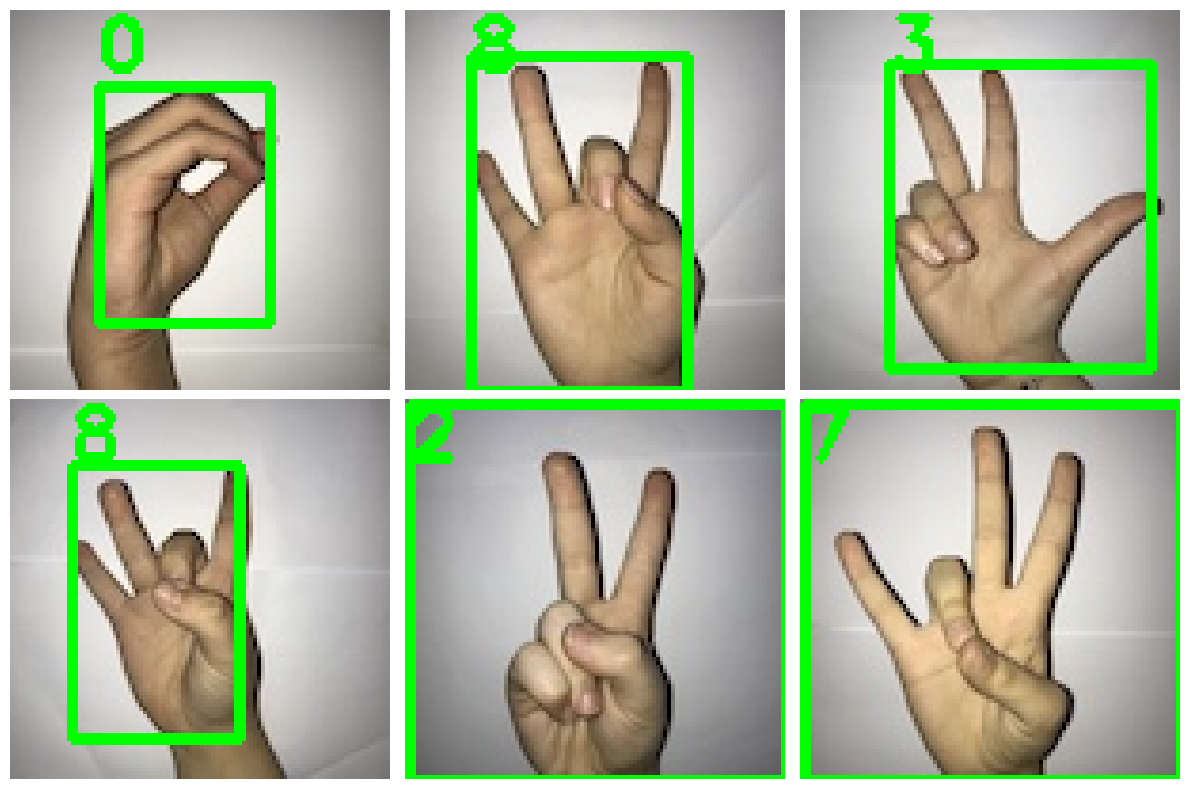

In [7]:
# shows a few train images with the auto box drawn
import random, cv2, xml.etree.ElementTree as ET
from pathlib import Path
import matplotlib.pyplot as plt

IMGS = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\Tensorflow\workspace\images\train")
xmls = list(IMGS.glob("*.xml"))
samples = random.sample(xmls, min(6, len(xmls)))

plt.figure(figsize=(12,8))
for i, xp in enumerate(samples):
    root = ET.parse(xp).getroot()
    fn = root.find('filename').text
    img = cv2.imread(str(IMGS / fn))
    for obj in root.findall('object'):
        name = obj.find('name').text
        b = obj.find('bndbox')
        x1,y1,x2,y2 = [int(b.find(t).text) for t in ('xmin','ymin','xmax','ymax')]
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, name, (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.subplot(2,3,i+1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.tight_layout(); plt.show()


In [8]:
!python Tensorflow\scripts\preprocessing\xml_to_csv.py -i Tensorflow\workspace\images\train -o Tensorflow\workspace\annotations\train_labels.csv

C:\Users\sayu\AppData\Local\Programs\Python\Python311\python.exe: can't open file 'C:\\Users\\sayu\\Desktop\\Sign_Language\\RealTimeObjectDetection\\Tensorflow\\scripts\\preprocessing\\xml_to_csv.py': [Errno 2] No such file or directory


In [2]:
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd

BASE = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
TRAIN_DIR = BASE / r"Tensorflow\workspace\images\train"
TEST_DIR  = BASE / r"Tensorflow\workspace\images\test"
ANN_DIR   = BASE / r"Tensorflow\workspace\annotations"
ANN_DIR.mkdir(parents=True, exist_ok=True)

def voc_to_df(folder: Path):
    rows = []
    for xp in folder.glob("*.xml"):
        root = ET.parse(xp).getroot()
        filename = root.find("filename").text
        size = root.find("size")
        w = int(size.find("width").text); h = int(size.find("height").text)
        for obj in root.findall("object"):
            cls = obj.find("name").text
            bb  = obj.find("bndbox")
            xmin = int(bb.find("xmin").text)
            ymin = int(bb.find("ymin").text)
            xmax = int(bb.find("xmax").text)
            ymax = int(bb.find("ymax").text)
            rows.append([filename, w, h, cls, xmin, ymin, xmax, ymax])
    return pd.DataFrame(rows, columns=["filename","width","height","class","xmin","ymin","xmax","ymax"])

df_train = voc_to_df(TRAIN_DIR)
df_test  = voc_to_df(TEST_DIR)

df_train.to_csv(ANN_DIR/"train_labels.csv", index=False)
df_test.to_csv(ANN_DIR/"test_labels.csv", index=False)

print("CSV written:")
print(" -", ANN_DIR/"train_labels.csv")
print(" -", ANN_DIR/"test_labels.csv")
print(df_train.head())


CSV written:
 - C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\Tensorflow\workspace\annotations\train_labels.csv
 - C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\Tensorflow\workspace\annotations\test_labels.csv
                filename  width  height class  xmin  ymin  xmax  ymax
0  0_IMG_1118_000000.jpg    100     100     0    36    18    61    62
1  0_IMG_1138_000002.jpg    100     100     0    34    21    59    77
2  0_IMG_1148_000003.jpg    100     100     0    28    13    68    83
3  0_IMG_1158_000004.jpg    100     100     0    28     8    74    75
4  0_IMG_1169_000005.jpg    100     100     0    22     9    63    78


In [1]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas==2.2.2"])


0

In [4]:
# --- Robust TFRecord writer for Pascal VOC (train & test) ---

import tensorflow as tf
from pathlib import Path
import xml.etree.ElementTree as ET
import os

BASE = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
TRAIN_DIR = BASE / r"Tensorflow\workspace\images\train"
TEST_DIR  = BASE / r"Tensorflow\workspace\images\test"
ANN_DIR   = BASE / r"Tensorflow\workspace\annotations"
LABEL_MAP = ANN_DIR / "label_map.pbtxt"

def parse_label_map(pbtxt_path: Path):
    m = {}
    name = _id = None
    for line in pbtxt_path.read_text().splitlines():
        t = line.strip()
        if t.startswith("name:"):
            name = t.split(":",1)[1].strip().strip('"')
        elif t.startswith("id:"):
            _id = int(t.split(":",1)[1].strip())
        if name is not None and _id is not None:
            m[name] = _id
            name = _id = None
    return m

name_to_id = parse_label_map(LABEL_MAP)
print("Label map:", name_to_id)

def to_example(img_path: Path, xml_root: ET.Element):
    filename = xml_root.find("filename").text

    # Prefer width/height from XML (what LabelImg writes)
    size = xml_root.find("size")
    if size is not None:
        w = int(size.find("width").text); h = int(size.find("height").text)
    else:
        # Fallback: decode to get shape
        img_tmp = tf.io.decode_image(img_path.read_bytes(), channels=3)
        h = int(tf.shape(img_tmp)[0].numpy()); w = int(tf.shape(img_tmp)[1].numpy())

    img_bytes = img_path.read_bytes()

    xmins, ymins, xmaxs, ymaxs = [], [], [], []
    classes_text, classes = [], []

    for obj in xml_root.findall("object"):
        name = obj.find("name").text
        bb = obj.find("bndbox")
        xmin = float(bb.find("xmin").text) / w
        ymin = float(bb.find("ymin").text) / h
        xmax = float(bb.find("xmax").text) / w
        ymax = float(bb.find("ymax").text) / h

        # clip + validate
        xmin = max(0.0, min(1.0, xmin))
        ymin = max(0.0, min(1.0, ymin))
        xmax = max(0.0, min(1.0, xmax))
        ymax = max(0.0, min(1.0, ymax))
        if xmax <= xmin or ymax <= ymin:
            continue

        xmins.append(xmin); ymins.append(ymin); xmaxs.append(xmax); ymaxs.append(ymax)
        classes_text.append(name.encode("utf8"))
        classes.append(name_to_id[name])

    feat = tf.train.Features(feature={
        "image/height": tf.train.Feature(int64_list=tf.train.Int64List(value=[h])),
        "image/width":  tf.train.Feature(int64_list=tf.train.Int64List(value=[w])),
        "image/filename": tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode("utf8")])),
        "image/source_id": tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode("utf8")])),
        "image/encoded": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes])),
        "image/format": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_path.suffix.lower().strip('.').encode('utf8')])),
        "image/object/bbox/xmin": tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        "image/object/bbox/xmax": tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        "image/object/bbox/ymin": tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        "image/object/bbox/ymax": tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        "image/object/class/text": tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        "image/object/class/label": tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    })
    return tf.train.Example(features=feat)

def write_tfrecord_from_dir(img_dir: Path, out_path: Path):
    n_examples, n_missing = 0, 0
    with tf.io.TFRecordWriter(str(out_path)) as w:
        for xml_path in img_dir.glob("*.xml"):
            root = ET.parse(xml_path).getroot()
            filename = root.find("filename").text
            img_path = img_dir / filename
            if not img_path.exists():
                n_missing += 1
                continue
            ex = to_example(img_path, root)
            w.write(ex.SerializeToString()); n_examples += 1
    print(f"Wrote {n_examples} examples (skipped {n_missing} missing) -> {out_path}  ({os.path.getsize(out_path)/1e6:.2f} MB)")

write_tfrecord_from_dir(TRAIN_DIR, ANN_DIR/"train.record")
write_tfrecord_from_dir(TEST_DIR,  ANN_DIR/"test.record")


Label map: {'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
Wrote 1649 examples (skipped 0 missing) -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\Tensorflow\workspace\annotations\train.record  (19.50 MB)
Wrote 413 examples (skipped 0 missing) -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\Tensorflow\workspace\annotations\test.record  (5.61 MB)


In [3]:
import tensorflow as tf
from pathlib import Path

DATA_DIR = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\data\raw_images")
IMG_SIZE = (128, 128)
BATCH = 32
SEED = 1337

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset='training', seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode='int'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset='validation', seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode='int'
)

# cache/prefetch to speed up CPU training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

# Simple, fast CNN (no external weights)
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPool2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPool2D(),
    layers.Conv2D(128,3, activation='relu'), layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # classes 0..9
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_ds, validation_data=val_ds, epochs=12)  # bump epochs if you want
MODEL_PATH = r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\models\sign_digits_classifier.keras"
Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
model.save(MODEL_PATH)
print("Saved:", MODEL_PATH)


Found 2062 files belonging to 10 classes.
Using 1650 files for training.
Found 2062 files belonging to 10 classes.
Using 412 files for validation.



Epoch 1/12


52/52 [==============================] - 52s 949ms/step - loss: 1.8114 - accuracy: 0.3479 - val_loss: 0.9488 - val_accuracy: 0.7184
Epoch 2/12
52/52 [==============================] - 44s 859ms/step - loss: 0.9528 - accuracy: 0.6867 - val_loss: 0.5838 - val_accuracy: 0.8204
Epoch 3/12
52/52 [==============================] - 46s 894ms/step - loss: 0.6897 - accuracy: 0.7758 - val_loss: 0.5601 - val_accuracy: 0.7961
Epoch 4/12
52/52 [==============================] - 48s 917ms/step - loss: 0.5682 - accuracy: 0.8097 - val_loss: 0.4713 - val_accuracy: 0.8471
Epoch 5/12
52/52 [==============================] - 47s 904ms/step - loss: 0.4397 - accuracy: 0.8582 - val_loss: 0.4095 - val_accuracy: 0.8762
Epoch 6/12
52/52 [==============================] - 51s 973ms/step - loss: 0.3404 - accuracy: 0.8812 - val_loss: 0.3435 - val_accurac

In [1]:
import tensorflow as tf, numpy as np
from pathlib import Path

MODEL_PATH = r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\models\sign_digits_classifier.keras"
DATA_DIR   = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\data\raw_images")
IMG_SIZE   = (128,128)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset='validation', seed=1337,
    image_size=IMG_SIZE, batch_size=32, label_mode='int', shuffle=False
)

model = tf.keras.models.load_model(MODEL_PATH)

y_true, y_pred = [], []
for x, y in val_ds:
    p = model.predict(x, verbose=0)
    y_true += y.numpy().tolist()
    y_pred += np.argmax(p, axis=1).tolist()

acc = np.mean(np.array(y_true)==np.array(y_pred))
print(f"Validation accuracy (recomputed): {acc:.3f}")

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=10).numpy()
print("Confusion matrix (rows=true, cols=pred):\n", cm)



Found 2062 files belonging to 10 classes.
Using 412 files for validation.



Validation accuracy (recomputed): 0.978
Confusion matrix (rows=true, cols=pred):
 [[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   2 199   7]
 [  0   0   0   0   0   0   0   0   0 204]]


In [ ]:
import cv2, numpy as np, mediapipe as mp, tensorflow as tf
from collections import deque
from pathlib import Path
import time


MODEL_PATH = r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\models\sign_digits_classifier.keras"
IMG_SIZE   = (128, 128)
CONF_MIN   = 0.40
SMOOTH_N   = 7
MIRROR     = True

if not Path(MODEL_PATH).exists():
    raise SystemExit(f"Model not found: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1,
                       min_detection_confidence=0.5, min_tracking_confidence=0.5)

def make_square_bbox(x1, y1, x2, y2, W, H, extra=0.18):
    # expand by margin
    cx, cy = (x1+x2)/2, (y1+y2)/2
    w, h = (x2-x1), (y2-y1)
    side = max(w, h)
    side = int(side * (1.0 + extra))
    x1s = int(max(0, cx - side/2)); y1s = int(max(0, cy - side/2))
    x2s = int(min(W-1, x1s + side)); y2s = int(min(H-1, y1s + side))

    # re-center if clipped on edges
    if x2s - x1s < side:
        x1s = max(0, x2s - side)
    if y2s - y1s < side:
        y1s = max(0, y2s - side)
    return x1s, y1s, x2s, y2s

def letterbox(img, size):
    """Resize with unchanged aspect using padding to 'size' (w,h)."""
    th, tw = size[1], size[0]   # size = (W,H)
    h, w = img.shape[:2]
    scale = min(tw / w, th / h)
    nw, nh = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (nw, nh))
    canvas = np.zeros((th, tw, 3), dtype=img.dtype)
    top  = (th - nh) // 2
    left = (tw - nw) // 2
    canvas[top:top+nh, left:left+nw] = resized
    return canvas


def lm_to_bbox(lms, margin=0.15):
    xs=[lm.x for lm in lms]; ys=[lm.y for lm in lms]
    x1,x2=max(0.0,min(xs)),min(1.0,max(xs))
    y1,y2=max(0.0,min(ys)),min(1.0,max(ys))
    mx=margin*(x2-x1+1e-6); my=margin*(y2-y1+1e-6)
    return max(0.0,x1-mx),max(0.0,y1-my),min(1.0,x2+mx),min(1.0,y2+my)

def open_cam():
    for backend in (cv2.CAP_DSHOW, cv2.CAP_ANY):
        for cam_id in (0,1,2):
            cap = cv2.VideoCapture(cam_id, backend)
            if cap.isOpened(): return cap
            cap.release()
    return None

cap = open_cam()
if cap is None:
    raise SystemExit("No webcam found (tried 0/1/2). Close other apps and try again.")

vote = deque(maxlen=SMOOTH_N); prev_t=time.time(); fps=0.0
print("Press 'q' or ESC to quit")

while True:
    ok, frame = cap.read()
    if not ok: break
    if MIRROR: frame = cv2.flip(frame, 1)

    h, w = frame.shape[:2]
    res = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if res.multi_hand_landmarks:
        lms = res.multi_hand_landmarks[0].landmark
        x1n,y1n,x2n,y2n = lm_to_bbox(lms, margin=0.15)
        x1,y1,x2,y2 = int(x1n*w),int(y1n*h),int(x2n*w),int(y2n*h)
        x1,y1=max(0,x1),max(0,y1); x2,y2=min(w-1,x2),min(h-1,y2)

        crop = frame[y1:y2, x1:x2]
        if crop.size and (x2-x1) > 10 and (y2-y1) > 10:
    # ---- robust square + letterbox pipeline ----
    # 1) make square bbox around the mediapipe box with extra margin
        x1s, y1s, x2s, y2s = make_square_bbox(x1, y1, x2, y2, w, h, extra=0.18)
        crop_sq = frame[y1s:y2s, x1s:x2s]

    # 2) BGR -> RGB to match training
        rgb = cv2.cvtColor(crop_sq, cv2.COLOR_BGR2RGB)

    # 3) letterbox to IMG_SIZE (no distortion)
        inp = letterbox(rgb, IMG_SIZE)

    # 4) prepare tensor (NO /255 if the model already has Rescaling)
        x = inp.astype(np.float32)[None, ...]
    # If your model does NOT have a Rescaling layer, use this instead:
    # x = (inp.astype(np.float32) / 255.0)[None, ...]

        p = model.predict(x, verbose=0)[0]
        cls = int(np.argmax(p)); conf = float(p[cls])

    # draw the square box (not the original mediapipe rectangle)
        cv2.rectangle(frame, (x1s, y1s), (x2s, y2s), (0,255,0), 2)

        if conf >= CONF_MIN:
            vote.append(cls)
            label_main = f"{max(set(vote), key=vote.count)}  {conf:.2f}"
        else:
            label_main = "?"

    # show top-3 to debug
        top3 = np.argsort(p)[-3:][::-1]
        label_top3 = " ".join([f"{i}:{p[i]:.2f}" for i in top3])

        cv2.putText(frame, label_main, (x1s, max(20, y1s-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        cv2.putText(frame, label_top3, (x1s, y2s + 22),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    now=time.time(); fps=fps*0.9 + (1.0/max(1e-6, now-prev_t))*0.1; prev_t=now
    cv2.putText(frame,f"FPS: {fps:.1f}",(10,25),
                cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)
    cv2.imshow("Sign Digit (0–9) — realtime (no matplotlib)", frame)
    if cv2.waitKey(1) & 0xFF in (27, ord('q')): break

cap.release(); cv2.destroyAllWindows(); hands.close()


In [5]:
print(model.layers[0].__class__.__name__)

Rescaling


In [6]:
from pathlib import Path
import cv2, numpy as np, tensorflow as tf

MODEL_PATH = r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\models\sign_digits_classifier.keras"
DATA_DIR   = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\data\raw_images")
IMG_SIZE   = (128,128)

model = tf.keras.models.load_model(MODEL_PATH)

def predict_path(p):
    bgr = cv2.imread(str(p))
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    x   = cv2.resize(rgb, IMG_SIZE).astype(np.float32)[None,...]
    probs = model.predict(x, verbose=0)[0]
    print(p, "->", int(np.argmax(probs)), float(np.max(probs)))

# one example from class 0 and one from class 5
predict_path(next((DATA_DIR/'0').glob('*')))
predict_path(next((DATA_DIR/'5').glob('*')))


C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\data\raw_images\0\IMG_1118.JPG -> 0 0.9960850477218628
C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\data\raw_images\5\IMG_1123.JPG -> 5 0.998874843120575
